In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Read the dataset and select the signal we are interested in.

In [27]:
signal_name = 'L_T1'

In [28]:
file_name = "trn_set_1"
DATA_PATH = r"C:../data/{}.csv".format(file_name)

data_train1 = pd.read_csv(DATA_PATH, parse_dates=['DATETIME'], index_col = ['DATETIME'], dayfirst=True)

#Drop the discrete columns
data_train1.drop(columns = ['S_PU1', 'S_PU2', 'S_PU3', 'S_PU4', 'S_PU5', 'S_PU6', 'S_PU7', 'S_PU8', 'S_PU9', 'S_PU10', 'S_PU11', 'S_V2'], inplace=True)

#signal = pd.Series(data_train1[signal_name], data_train1.index)
#signal.head()

Let's define a function for discretizing the signal series.

In [29]:
def discretize_signal(signal, n_bins):
    return pd.qcut(signal, n_bins, labels = False)

In [30]:
def plot_discrete(signal,window, n_bins):
    signal_continuous = signal[:window]
    signal_discretized = discretize_signal(signal_continuous, n_bins)
    
    plt.figure(figsize=(17, 3))
    plt.plot(signal_continuous)
    plt.title("Original signal")
    plt.show()
    
    plt.figure(figsize=(17, 3))
    plt.step(signal_discretized.index, signal_discretized)
    plt.title("Discretized signal")
    plt.show()

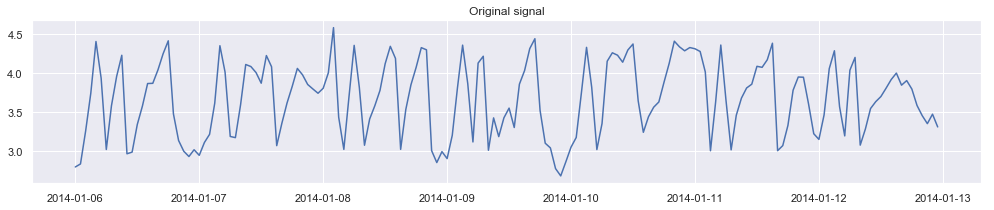

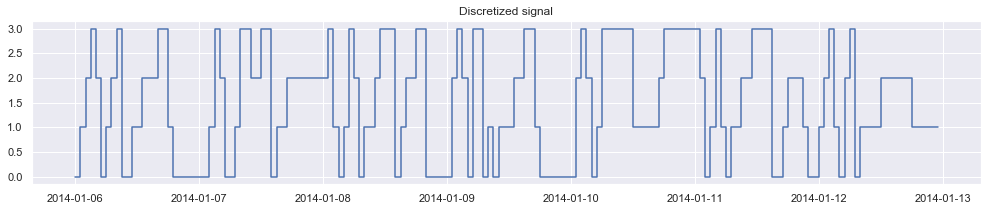

In [31]:
n_bins = 4
n_hours = 24*7
plot_discrete(signal, n_hours, n_bins)

Let's work on n-grams now. 
First, we define a function for generating all the n-grams given the discretized signal, where n is defined by the user.

In [ ]:
n = 7 # for n-grams

In [6]:
def get_ngrams(discrete_signal, n):
    return zip(*[discrete_signal[index:] for index in range(n)])

In [ ]:
# uncomment this only if you want to print the ngrams

# ng = get_ngrams(discretize_signal(signal, n_bins),n)
# for ngram in ng:
#    print(ngram)

Let's define a function for computing the probabilities for the generated n-grams based on the given discretized signal. n is defined by the user. We apply Laplace smoothing for the probabilities.

In [7]:
def ngram_probabilities(discrete_signal, n):
    
    #Define a dicitonary for counting each n-gram
    ngrams_count = {}
    
    #Let's generate the n-grams and 
    ngrams = get_ngrams(discrete_signal, n)
    
    for ngram in ngrams:
        if ngram in ngrams_count.keys():
            ngrams_count[ngram] += 1
        else:
            ngrams_count[ngram] = 1
            
    #Compute the total number of ngrams for computing probabilities
    total_ngrams = sum(ngrams_count.values())
    #print(len(ngrams_count.keys()))
    #print(total_ngrams)
    
    #Compute the total number of ngrams we could have for performing Laplace smoothing
    total_possible_ngrams = discrete_signal.nunique()**n
    #print(total_possible_ngrams)
    
    #Compute the smoothed probability for each n-gram
    for key in ngrams_count.keys():
        ngrams_count[key] = (ngrams_count[key] + 1)/(total_ngrams + total_possible_ngrams)
        
    #Save the probability for other n-grams that we did not encounter during training
    ngrams_count['other'] = 1/(total_ngrams + total_possible_ngrams)
        
    #for key in ngrams_count.keys():
    #    print(f"{key}: {ngrams_count[key]}")
        
    return ngrams_count   
    

In [ ]:
ngrams_prob_dict = ngram_probabilities(discretize_signal(signal, n_bins), n)

We need to compute the n-grams on the training set 1 because, as specified in the documentation, there are no attacks in that dataset. We need to compute the n-grams probabilities based on normal data and then use these to detect abnormal behaviour in the other dataset.

In [ ]:
#discretize the signal
discrete_signal = discretize_signal(signal, n_bins)

#get the ngrams probabilities for this training data
ngrams_prob = ngram_probabilities(discrete_signal, n)

#print(ngrams_prob)

Sliding window: if we have a too long sliding window, we might end up not detecting any anomaly (if it's too long, most of the ngrams will have been probably seen in the training --> normal behaviour). If we have a too short sliding window, we might end up raising too many alarms: each n-gram which was not in the training would raise an alarm --> too many.

Let's take the dataset 2, which has attacks, and discretize it.

In [8]:
file_name = "trn_set_2"
DATA_PATH = r"C:../data/{}.csv".format(file_name)

data_train2 = pd.read_csv(DATA_PATH, parse_dates=['DATETIME'], index_col = ['DATETIME'], dayfirst=True)
#signal2 = pd.Series(data_train2[signal_name])

#discretize the signal
#discrete_signal2 = discretize_signal(signal2, n_bins)

Now we are sliding over this signal with a bigger window that the one used for computing n-grams, for the reasons explained above.

In [ ]:
window_anomaly_checking = 10

detection_series = pd.DataFrame(np.ones(discrete_signal2.size), discrete_signal2.index)

for num_idx, index in enumerate(discrete_signal2.index[:-window_anomaly_checking+1]):
    subset_series = discrete_signal2.iloc[num_idx:(num_idx+window_anomaly_checking)]
        
    subset_ngrams = get_ngrams(subset_series, n)
    prob_product = 1
    for ngram in subset_ngrams:
        if ngram in ngrams_prob.keys():
            prob_product *= ngrams_prob[ngram]
        else:
            prob_product *= ngrams_prob['other']
    
    
    for num_idx_det, index_det in enumerate(detection_series.index[num_idx:(num_idx+window_anomaly_checking)]):
        if detection_series.loc[index_det].item() > prob_product:
            detection_series.loc[index_det] = prob_product
                    

In [ ]:
start='2016-10-26'
end='2016-11-05'
            
plt.figure(figsize=(17, 3))
plt.plot(detection_series)
plt.yscale("log")
plt.title("Prob")
plt.show()    

plt.figure(figsize=(17, 3))
plt.plot(data_train2['ATT_FLAG'])
plt.show()    

plt.figure(figsize=(17, 3))
plt.plot(signal2)
plt.show()   

Let's apply Grid Search:

In [9]:
def get_conf_mat_entry(results, true_attack, pred_attack):
    # just a helper function
    result = results[
        (results['true'] == (1 if true_attack else 0)) 
        & 
        (results['pred'] == (1 if pred_attack else 0))
    ]
    #print(result.shape[0])
    return result.shape[0]

In [10]:
def grid_search_for_signal(signal, signal2):
    n_bins = [3,4]
    n = [3,4,5,6]
    window_detection = [7,10,15,20,24]
    threshold = [1.1, 1.5, 1.75, 2,3,5,7,10,15, 25, 50, 75, 100, 150, 300, 500] #this is by how much we increase the min probability


    f1_best = 0
    n_bins_best = 0
    n_best = 0
    threshold_best = 0
    window_best = 0
    precision_best = 0
    recall_best = 0
    tp_best = 0
    tn_best = 0
    fp_best = 0
    fn_best = 0

    for current_n_bins in n_bins:
        #discretize the signal
        discrete_signal = discretize_signal(signal, current_n_bins)
        discrete_signal2 = discretize_signal(signal2, current_n_bins)

        for current_n in n:
            #get the ngrams probabilities for this training data
            ngrams_prob = ngram_probabilities(discrete_signal, current_n)

            for current_window in window_detection:  

                detection_series = pd.DataFrame(np.ones(discrete_signal2.size), discrete_signal2.index)

                for num_idx, index in enumerate(discrete_signal2.index[:-current_window+1]):
                    subset_series = discrete_signal2.iloc[num_idx:(num_idx+current_window)]

                    subset_ngrams = get_ngrams(subset_series, current_n)
                    prob_product = 1
                    for ngram in subset_ngrams:
                        if ngram in ngrams_prob.keys():
                            prob_product *= ngrams_prob[ngram]
                        else:
                            prob_product *= ngrams_prob['other']

                    for num_idx_det, index_det in enumerate(detection_series.index[num_idx:(num_idx+current_window)]):
                        if detection_series.loc[index_det].item() > prob_product:
                            detection_series.loc[index_det] = prob_product

                #Loop over threshold values
                for current_threshold in threshold:
                    min_prob = np.min(detection_series).item()

                    final_detection = pd.DataFrame(np.zeros(discrete_signal2.size), discrete_signal2.index)

                    thresh = current_threshold * min_prob

                    for num_idx_det, index_det in enumerate(detection_series.index):
                        if detection_series.loc[index_det].item() < thresh:
                            final_detection.loc[index_det] = 1


                    #print(f"Number of bins {current_n_bins}, n-grams {current_n}, window size {current_window}, threshold {current_threshold}")

                    #Compute F1 score

                    res = pd.concat([data_train2['ATT_FLAG'].map({-999:0, 1:1}), final_detection], axis=1)
                    res.columns = ['true', 'pred']
                    res.set_index(final_detection.index)

                    t_p = get_conf_mat_entry(res, true_attack=True, pred_attack=True)
                    t_n = get_conf_mat_entry(res, true_attack=False, pred_attack=False)
                    f_p = get_conf_mat_entry(res, true_attack=False, pred_attack=True)
                    f_n = get_conf_mat_entry(res, true_attack=True, pred_attack=False)

                    precision = t_p/(t_p + f_p)
                    recall = t_p/(t_p + f_n)                

                    if (precision + recall ) == 0:
                        continue

                    f1 = ( 2 * precision * recall ) / (precision + recall )

                    if f1 > f1_best:
                        f1_best = f1
                        n_bins_best = current_n_bins
                        n_best = current_n
                        window_best = current_window
                        threshold_best = current_threshold
                        precision_best = precision
                        recall_best = recall
                        tp_best = t_p
                        tn_best = t_n
                        fp_best = f_p
                        fn_best = f_n

                        #print(f"UPDATED")
                        #print(f"f1: {f1}. TP: {t_p}. FP:{f_p}. TN:{t_n}. FN: {f_n}")

                        #print(f"Number of bins {current_n_bins}, n-grams {current_n}, window size {current_window}, threshold {current_threshold}")

                        
    plt.figure(figsize=(17,3))
    plt.plot(detection_series)
    plt.yscale("log")
    plt.title("Probabilities")
    plt.show()

    plt.figure(figsize=(17,3))
    plt.plot(final_detection)
    plt.title("Final detection")
    plt.show()

    return n_bins_best, n_best, window_best, threshold_best, f1_best, precision_best, recall_best, tp_best, tn_best, fp_best, fn_best
                    
                    



Let's run Grid Search for all the different continuous signals in the dataset.

I am at signal L_T1


C:\Users\biby_\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


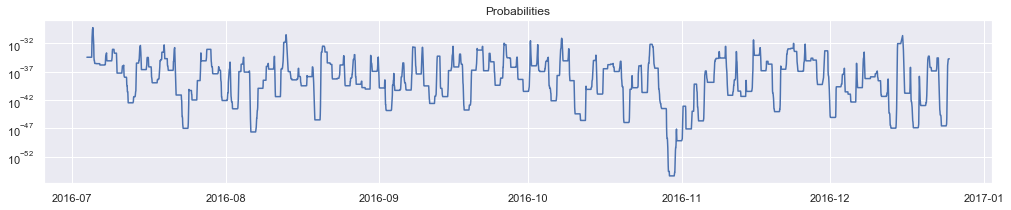

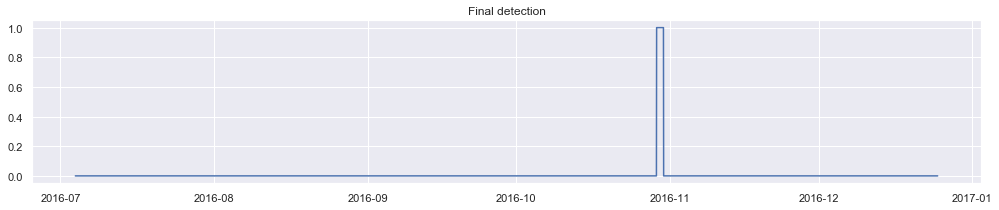

Signal L_T1 best configuration is n_bins 3, n 4, window 20, threshold 500 and F1 score 0.23364485981308408, precision 0.23923444976076555, recall 0.228310502283105, TP 50, TN 3799, FP 159, FN 169
I am at signal L_T2


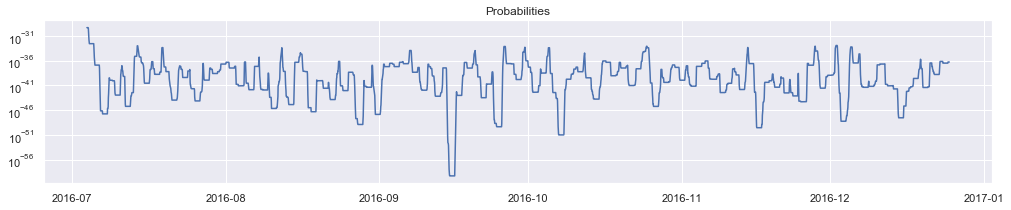

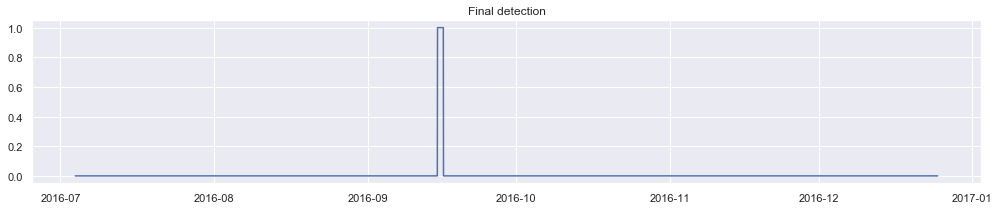

Signal L_T2 best configuration is n_bins 4, n 3, window 24, threshold 5 and F1 score 0.21705426356589147, precision 0.717948717948718, recall 0.1278538812785388, TP 28, TN 3947, FP 11, FN 191
I am at signal L_T3


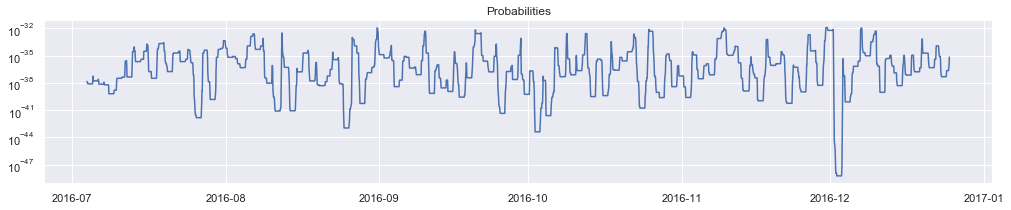

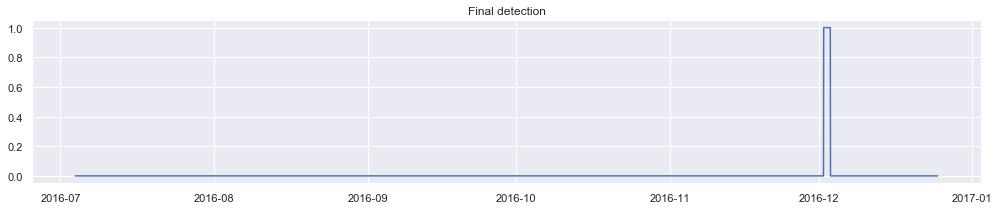

Signal L_T3 best configuration is n_bins 3, n 3, window 20, threshold 15 and F1 score 0.13930348258706465, precision 0.0851063829787234, recall 0.3835616438356164, TP 84, TN 3055, FP 903, FN 135
I am at signal L_T4


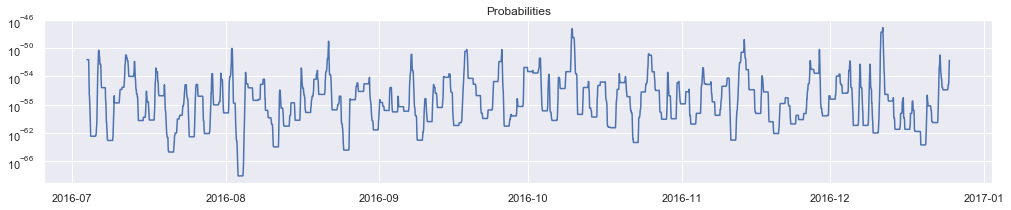

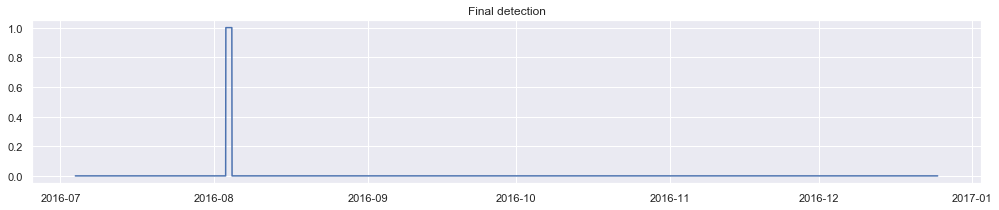

Signal L_T4 best configuration is n_bins 3, n 3, window 24, threshold 25 and F1 score 0.10367170626349892, precision 0.09836065573770492, recall 0.1095890410958904, TP 24, TN 3738, FP 220, FN 195
I am at signal L_T5


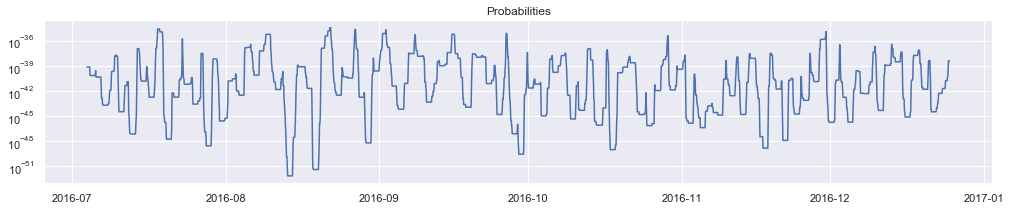

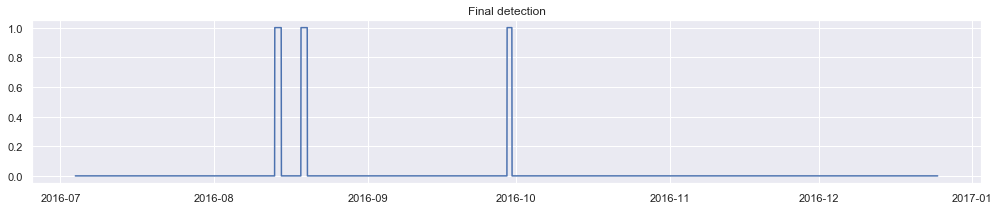

Signal L_T5 best configuration is n_bins 3, n 6, window 7, threshold 500 and F1 score 0.07028753993610223, precision 0.05405405405405406, recall 0.1004566210045662, TP 22, TN 3573, FP 385, FN 197
I am at signal L_T7


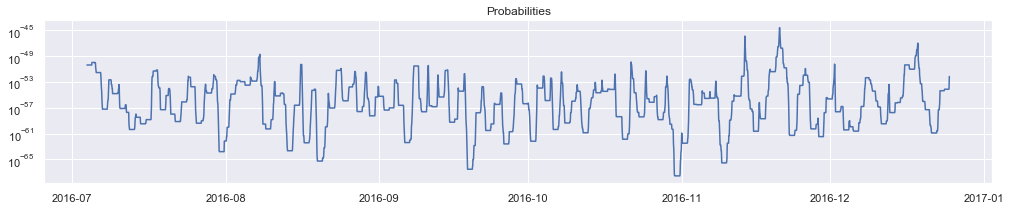

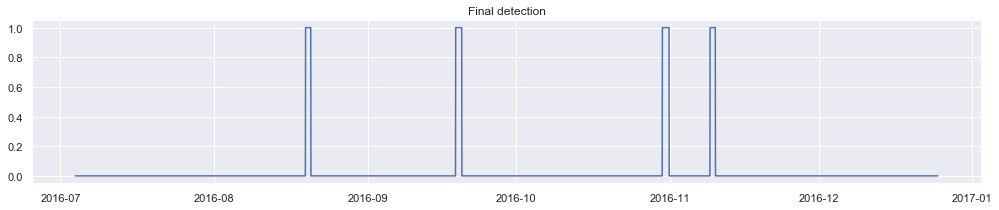

Signal L_T7 best configuration is n_bins 3, n 3, window 20, threshold 300 and F1 score 0.28491620111731847, precision 0.2052313883299799, recall 0.4657534246575342, TP 102, TN 3563, FP 395, FN 117
I am at signal F_PU1


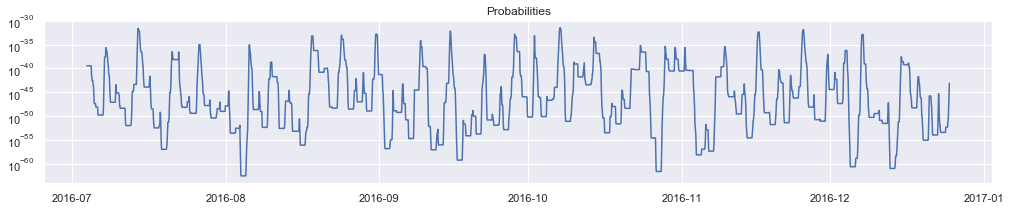

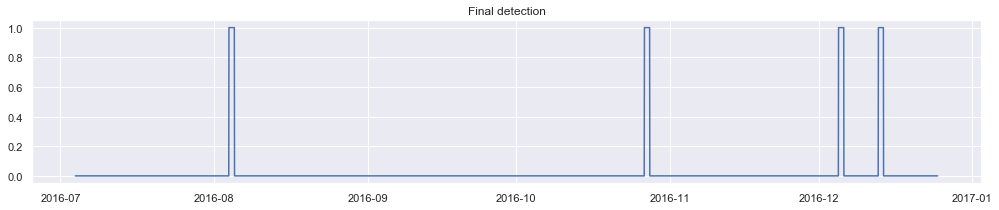

Signal F_PU1 best configuration is n_bins 3, n 5, window 10, threshold 75 and F1 score 0.1451104100946372, precision 0.23469387755102042, recall 0.1050228310502283, TP 23, TN 3883, FP 75, FN 196
I am at signal F_PU7


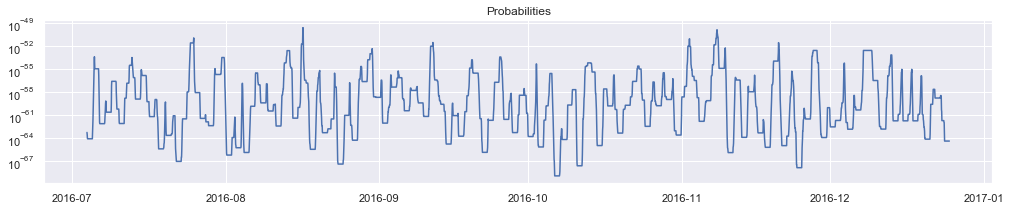

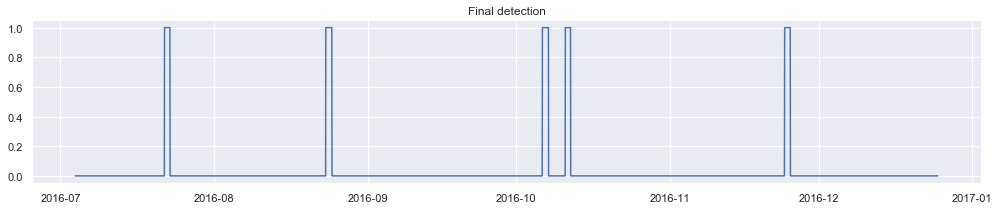

Signal F_PU7 best configuration is n_bins 4, n 6, window 10, threshold 5 and F1 score 0.1853932584269663, precision 0.24087591240875914, recall 0.1506849315068493, TP 33, TN 3854, FP 104, FN 186
I am at signal F_PU8


ValueError: Bin edges must be unique: array([ 0.        ,  0.        , 35.24258041, 39.13399506]).
You can drop duplicate edges by setting the 'duplicates' kwarg

In [12]:
#Get the signal names
signal_names = list(data_train1.columns.values)
signal_names.remove('ATT_FLAG')
signal_names.remove('L_T6') #doesn't work
signal_names.remove('F_PU2') #doesn't work
signal_names.remove('F_PU3') #doesn't work
signal_names.remove('F_PU4') #doesn't work
signal_names.remove('F_PU5') #doesn't work
signal_names.remove('F_PU6') #doesn't work


grid_values = {}

#For each signal, discretize it and run Grid search
for signal in signal_names:
    print(f"I am at signal {signal}")
    params = grid_search_for_signal(data_train1[signal], data_train2[signal])
    grid_values[signal] = params
    
    print(f"Signal {signal} best configuration is n_bins {params[0]}, n {params[1]}, window {params[2]}, threshold {params[3]} and F1 score {params[4]}, precision {params[5]}, recall {params[6]}, TP {params[7]}, TN {params[8]}, FP {params[9]}, FN {params[10]}")
    




In [13]:
print(grid_values)

{'L_T1': (3, 4, 20, 500, 0.23364485981308408, 0.23923444976076555, 0.228310502283105, 50, 3799, 159, 169), 'L_T2': (4, 3, 24, 5, 0.21705426356589147, 0.717948717948718, 0.1278538812785388, 28, 3947, 11, 191), 'L_T3': (3, 3, 20, 15, 0.13930348258706465, 0.0851063829787234, 0.3835616438356164, 84, 3055, 903, 135), 'L_T4': (3, 3, 24, 25, 0.10367170626349892, 0.09836065573770492, 0.1095890410958904, 24, 3738, 220, 195), 'L_T5': (3, 6, 7, 500, 0.07028753993610223, 0.05405405405405406, 0.1004566210045662, 22, 3573, 385, 197), 'L_T7': (3, 3, 20, 300, 0.28491620111731847, 0.2052313883299799, 0.4657534246575342, 102, 3563, 395, 117), 'F_PU1': (3, 5, 10, 75, 0.1451104100946372, 0.23469387755102042, 0.1050228310502283, 23, 3883, 75, 196), 'F_PU7': (4, 6, 10, 5, 0.1853932584269663, 0.24087591240875914, 0.1506849315068493, 33, 3854, 104, 186)}


# Anomaly Types

Let's look at L_T1 first, since we have properly labeled attacks.

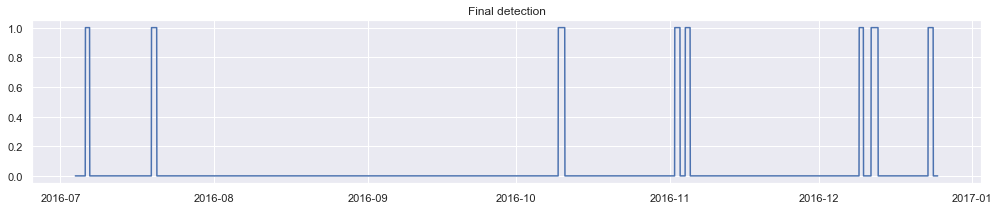

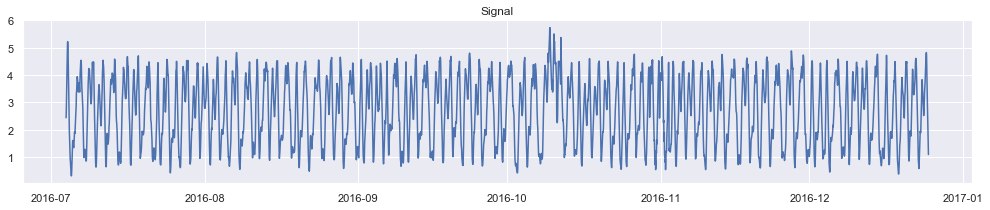

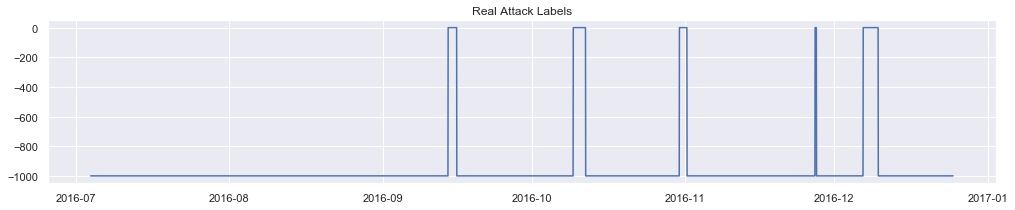

In [20]:
#read data
file_name1 = "trn_set_1"
file_name2 = "trn_set_2"

DATA_PATH1 = r"C:../data/{}.csv".format(file_name1)
DATA_PATH2 = r"C:../data/{}.csv".format(file_name2)


data_train1 = pd.read_csv(DATA_PATH1, parse_dates=['DATETIME'], index_col = ['DATETIME'], dayfirst=True)
data_train2 = pd.read_csv(DATA_PATH2, parse_dates=['DATETIME'], index_col = ['DATETIME'], dayfirst=True)

#choose signal for analysis
signal_name = 'L_T1'
signal = data_train1[signal_name]
signal2 = data_train2[signal_name]

#use the best parameter values obtained for grid search
n_bins = 3
n = 4
window = 20
threshold = 500

#discretize the signal
discrete_signal = discretize_signal(signal, n_bins)
discrete_signal2 = discretize_signal(signal2, n_bins)

#get the ngrams probabilities for this training data
ngrams_prob = ngram_probabilities(discrete_signal, n)

detection_series = pd.DataFrame(np.ones(discrete_signal2.size), discrete_signal2.index)

for num_idx, index in enumerate(discrete_signal2.index[:-window+1]):
    subset_series = discrete_signal2.iloc[num_idx:(num_idx+window)]

    subset_ngrams = get_ngrams(subset_series, n)
    prob_product = 1
    for ngram in subset_ngrams:
        if ngram in ngrams_prob.keys():
            prob_product *= ngrams_prob[ngram]
        else:
            prob_product *= ngrams_prob['other']

    for num_idx_det, index_det in enumerate(detection_series.index[num_idx:(num_idx+window)]):
        if detection_series.loc[index_det].item() > prob_product:
            detection_series.loc[index_det] = prob_product
            
            
min_prob = np.min(detection_series).item()

final_detection = pd.DataFrame(np.zeros(discrete_signal2.size), discrete_signal2.index)

thresh = threshold * min_prob

for num_idx_det, index_det in enumerate(detection_series.index):
    if detection_series.loc[index_det].item() < thresh:
        final_detection.loc[index_det] = 1
        
plt.figure(figsize=(17,3))
plt.plot(final_detection)
plt.title("Final detection")
plt.show()

plt.figure(figsize=(17,3))
plt.plot(signal2)
plt.title("Signal")
plt.show()

plt.figure(figsize=(17,3))
plt.plot(data_train2['ATT_FLAG'])
plt.title("Real Attack Labels")
plt.show()

Let's limit it in time when we have the attack for T1 and get a closer look at it.

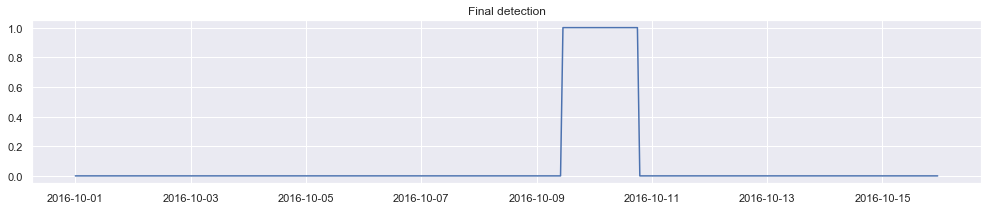

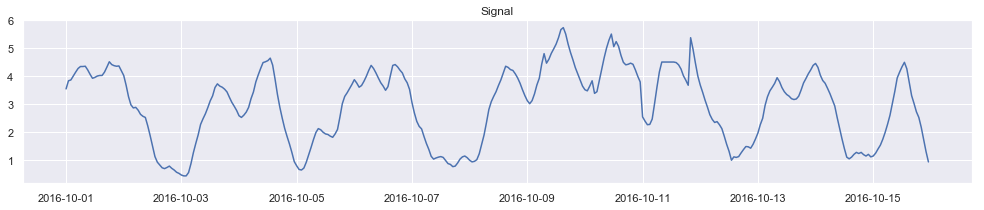

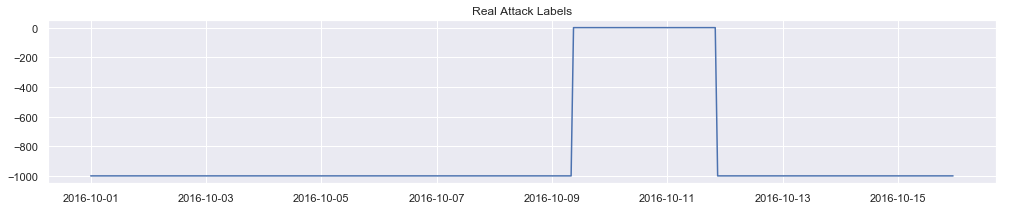

In [21]:
start_date = '2016-10-01'
end_date = '2016-10-15'


plt.figure(figsize=(17,3))
plt.plot(final_detection[start_date:end_date])
plt.title("Final detection")
plt.show()

plt.figure(figsize=(17,3))
plt.plot(signal2[start_date:end_date])
plt.title("Signal")
plt.show()

plt.figure(figsize=(17,3))
plt.plot(data_train2[start_date:end_date]['ATT_FLAG'])
plt.title("Real Attack Labels")
plt.show()
            

In the case of the 'L_T1' sensor this attack, according to the data documentation, results in overflow in T1. We can observe that the detection method manages to detect the anomaly, which is a collection of multiple **point anomalies**. 

Let's look at L_T4, since it also has labeled attacks.

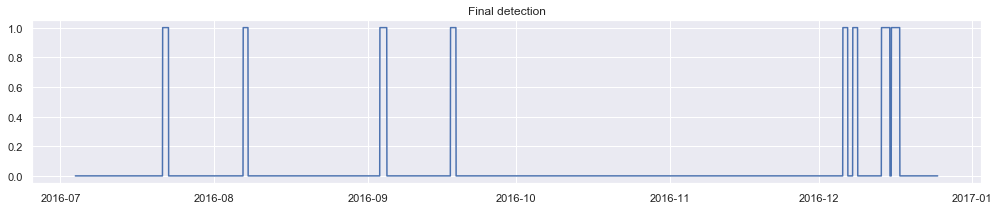

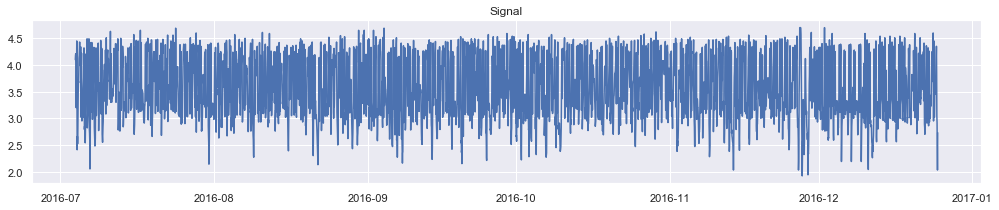

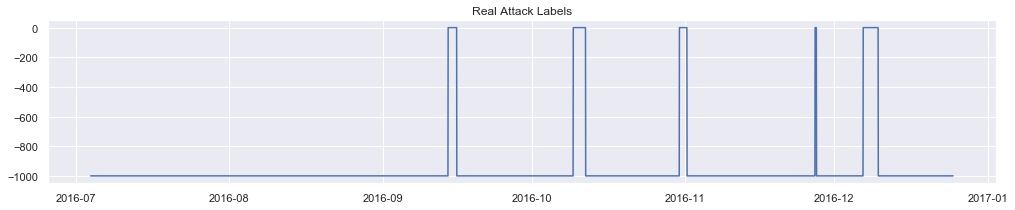

In [22]:
#read data
file_name1 = "trn_set_1"
file_name2 = "trn_set_2"

DATA_PATH1 = r"C:../data/{}.csv".format(file_name1)
DATA_PATH2 = r"C:../data/{}.csv".format(file_name2)


data_train1 = pd.read_csv(DATA_PATH1, parse_dates=['DATETIME'], index_col = ['DATETIME'], dayfirst=True)
data_train2 = pd.read_csv(DATA_PATH2, parse_dates=['DATETIME'], index_col = ['DATETIME'], dayfirst=True)

#choose signal for analysis
signal_name = 'L_T4'
signal = data_train1[signal_name]
signal2 = data_train2[signal_name]

#use the best parameter values obtained for grid search
n_bins = 3
n = 3
window = 24
threshold = 25

#discretize the signal
discrete_signal = discretize_signal(signal, n_bins)
discrete_signal2 = discretize_signal(signal2, n_bins)

#get the ngrams probabilities for this training data
ngrams_prob = ngram_probabilities(discrete_signal, n)

detection_series = pd.DataFrame(np.ones(discrete_signal2.size), discrete_signal2.index)

for num_idx, index in enumerate(discrete_signal2.index[:-window+1]):
    subset_series = discrete_signal2.iloc[num_idx:(num_idx+window)]

    subset_ngrams = get_ngrams(subset_series, n)
    prob_product = 1
    for ngram in subset_ngrams:
        if ngram in ngrams_prob.keys():
            prob_product *= ngrams_prob[ngram]
        else:
            prob_product *= ngrams_prob['other']

    for num_idx_det, index_det in enumerate(detection_series.index[num_idx:(num_idx+window)]):
        if detection_series.loc[index_det].item() > prob_product:
            detection_series.loc[index_det] = prob_product
            
            
min_prob = np.min(detection_series).item()

final_detection = pd.DataFrame(np.zeros(discrete_signal2.size), discrete_signal2.index)

thresh = threshold * min_prob

for num_idx_det, index_det in enumerate(detection_series.index):
    if detection_series.loc[index_det].item() < thresh:
        final_detection.loc[index_det] = 1
        
plt.figure(figsize=(17,3))
plt.plot(final_detection)
plt.title("Final detection")
plt.show()

plt.figure(figsize=(17,3))
plt.plot(signal2)
plt.title("Signal")
plt.show()

plt.figure(figsize=(17,3))
plt.plot(data_train2['ATT_FLAG'])
plt.title("Real Attack Labels")
plt.show()

We can see that we manage to detect the one in the beginning of December 2016. Let's have a closer look at it.

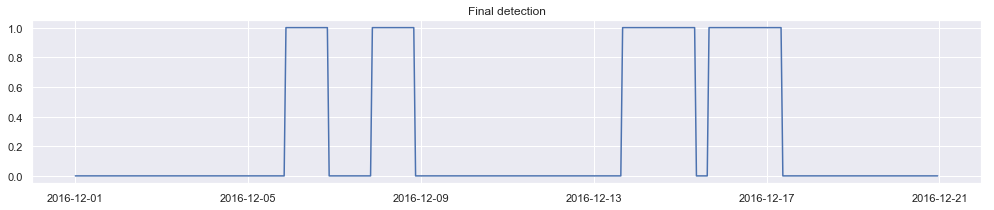

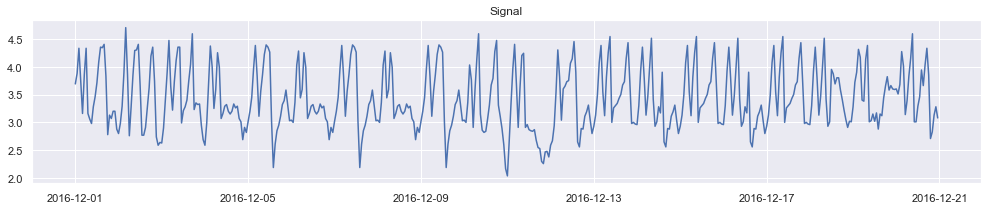

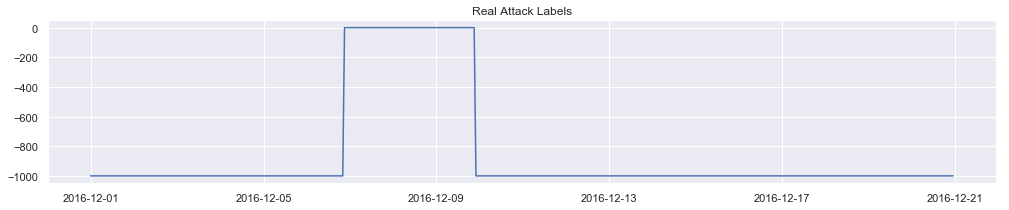

In [25]:
start_date = '2016-12-01'
end_date = '2016-12-20'


plt.figure(figsize=(17,3))
plt.plot(final_detection[start_date:end_date])
plt.title("Final detection")
plt.show()

plt.figure(figsize=(17,3))
plt.plot(signal2[start_date:end_date])
plt.title("Signal")
plt.show()

plt.figure(figsize=(17,3))
plt.plot(data_train2[start_date:end_date]['ATT_FLAG'])
plt.title("Real Attack Labels")
plt.show()

Also in this case, using the n-grams approach, we can detect multiple **point anomalies** for the labeled attack starting on 6th December 2016. Also, very nice to note is that the attack starting on 14th December, which also affects T4, is detected, although it is not labeled at all in the dataset. This attack also corresponds to multiple **point anomalies**, more specifically several points where the water level in T4 are lower than usual.